# Project 3: Emotion detection with Neural Networks
## CS4740/5740 Fall 2020

Names: Jennifer Russell & Giancarlo Soriano

Netids: jjr265 & gjs88

### Project Submission Due: November 13th
Please submit **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to project 1 instructions.



## Introduction
In this project we will consider **neural networks**: first a Feedforward Neural Network (FFNN) and second a Recurrent Neural Network (RNN), for performing a 5-class emotion detection task.

The project is divided into parts. In **Part 1**, you will be given an implementation for a FFNN and be asked to debug it in a specific way. In **Part 2**, you will then implement an RNN model for performing the same task. In **Part 3**, you will analyze these two models in two types of comparative studies and in **Part 4** you will answer questions describing what you have learned through this project. You also will be required to submit a description of libraries used, how your group divided up the work, and your feedback regarding the assignment (**Part 5**).

## Advice 🚀
As always, the report is important! The report is where you get to show
that you understand not only what you are doing but also why and how you are doing it. So be clear, organized and concise; avoid vagueness and excess verbiage. Spend time doing error analysis for the models. This is how you understand the advantages and drawbacks of the systems you build. The reports should read more like the papers that we have been writing critiques for.

All throughout the report you may be asked to place images, plots, etc. Feel free to write code that will generate the plots for you and use those or generate them some other way and insert into the colab. To add images in your colab, these are a few possible ways to do it!

1. Copy and paste the image in markdown! Yes this really does work

2. Upload to google drive, get a shareable link. It will be something like:

```
https://drive.google.com/file/d/1xDrydbSbijvK2JBftUz-5ovagN2B_RWH/view?usp=sharing
```
We want just the id which is `1xDrydbSbijvK2JBftUz-5ovagN2B_RWH` and the link we will use is:

```
https://drive.google.com/uc?export=view&id=your_id
```

Then in markdown you'd write the following:

```markdown
![image](https://drive.google.com/uc?export=view&id=1xDrydbSbijvK2JBftUz-5ovagN2B_RWH)
```

3. Using IPython!
```python
from IPython.display import Image
Image(filename="drive/GPU/data/iris.PNG")
```

4. Using your connected GDrive
```markdown
![iris](drive/GPU/data/iris.PNG)
```

## Dataset
You are given access to a set of tweets. These tweets have an associated
emotion $y \in Y := \{anger, fear, joy, love, sadness\}$. For this project, given the review text, you will
need to predict the associated rating, y. This is sometimes called fine-grained sentiment analysis in the literature; we will simply refer to it as sentiment analysis in this project.

We will minimally preprocess the reviews and handle tokenization in what we re-
lease. For this assignment, we do not anticipate any further preprocessing to be done by you. Should you choose to do so, it would be interesting to hear about in the report (along with whether or not it helped performance), but it is not a required aspect of the assignment.


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=9c909cd74481bfa69a6a9359049be51b06f2fc626af99d3dbc87dc3840e16883
  Stored in directory: /tmp/pip-ephem-wheel-cache-02p_miw2/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

train_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p3_train.txt") # replace based on your Google drive organization
val_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p3_val.txt") # replace based on your Google drive organization
test_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "p3_test_no_labels.txt") # replace based on your Google drive organization

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Part 1: Feedforward Neural Network

In this section, there are two main components relevant to **Part 1**.

1. `Data loader`\
As the name suggests, this section loads the data from the dataset files and handles other preprocessing and setup. You will **not** need to change this file and should **not** change this file throughout the assignment.

2. `ffnn`\
This contains the model and code that uses the model for **Part 1**

In the `ffnn` section, you will find a Feedforward Neural Net serving as the underlying model for performing emotion detection.



## Part 1: Tips

We do not assume you have **any** experience working with neural networks and/or debugging them. You may discover this process, while similar, is quite different from debuging in general software engineering and from debugging in other domains such as algorithms and systems.

We suggest you systematically step through the code and simultanously (perhaps by physically drawing it out) describe what the computations _mean_. What you are looking for is where the code differs from what is expected.

## Part 1: Rules

For **Part 1**, you will not be able to ask any questions on Piazza and we will be unable to provide any meaningful advice in office hours. Unfortunately, this is the nature of debugging, it is unlikely anyone can give you specific advice for most problems you encounter and we have already provided general tips in the preceding section, If you absolutely must ask a question or you believe there is some kind of issue with the assignment for this part, please submit a private Piazza post and we will respond swiftly.

As a reminder **communication about the assignment _between_ distinct groups is not permissed and is a violation of the Academic Integrity policy** For this assignment, we will be _extremely_ stringent about this, given that debugging is entirely pointless if someone else in a different group tells you where the error is.

## Import libraries and connect to Google Drive

In [ ]:
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import Dict, List, Set, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange

## Data loader

In [ ]:
emotion_to_idx = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5,
}
idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}
UNK = "<UNK>"

In [ ]:
optimdef fetch_data(train_data_path, val_data_path, test_data_path):
    """fetch_data retrieves the data from a json/csv and outputs the validation
    and training data

    :param train_data_path:
    :type train_data_path: str
    :return: Training, validation pair where the training is a list of document, label pairs
    :rtype: Tuple[
        List[Tuple[List[str], int]],
        List[Tuple[List[str], int]],
        List[List[str]]
    ]
    """
    with open(train_data_path) as training_f:
        training = training_f.read().split("\n")[1:-1]
    with open(val_data_path) as valid_f:
        validation = valid_f.read().split("\n")[1:-1]
    with open(test_data_path) as testing_f:
        testing = testing_f.read().split("\n")[1:-1]
	
    # If needed you can shrink the training and validation data to speed up somethings but this isn't always safe to do by setting k < 10000
    # k = #fill in
    # training = random.shuffle(training)
    # validation = random.shuffle(validation)
    # training, validation = training[:k], validation[:(k // 10)]

    tra = []
    val = []
    test = []
    for elt in training:
        if elt == '':
            continue
        txt, emotion = elt.split(",")
        tra.append((txt.split(" "), emotion_to_idx[emotion]))
    for elt in validation:
        if elt == '':
            continue
        txt, emotion = elt.split(",")
        val.append((txt.split(" "), emotion_to_idx[emotion]))
    for elt in testing:
        if elt == '':
            continue
        txt = elt
        test.append(txt.split(" "))

    return tra, val, test

In [ ]:
def make_vocab(data):
    """make_vocab creates a set of vocab words that the model knows

    :param data: The list of documents that is used to make the vocabulary
    :type data: List[str]
    :returns: A set of strings corresponding to the vocabulary
    :rtype: Set[str]
    """
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab 


def make_indices(vocab):
	"""make_indices creates a 1-1 mapping of word and indices for a vocab.

	:param vocab: The strings corresponding to the vocabulary in train data.
	:type vocab: Set[str]
	:returns: A tuple containing the vocab, word2index, and index2word.
		vocab is a set of strings in the vocabulary including <UNK>.
		word2index is a dictionary mapping tokens to its index (0, ..., V-1)
		index2word is a dictionary inverting the mapping of word2index
	:rtype: Tuple[
		Set[str],
		Dict[str, int],
		Dict[int, str],
	]
	"""
	vocab_list = sorted(vocab)
	vocab_list.append(UNK)
	word2index = {}
	index2word = {}
	for index, word in enumerate(vocab_list):
		word2index[word] = index 
		index2word[index] = word 
	vocab.add(UNK)
	return vocab, word2index, index2word 


def convert_to_vector_representation(data, word2index, test=False):
	"""convert_to_vector_representation converts the list of strings into a vector

	:param data: The dataset to be converted into a vectorized format
	:type data: Union[
		List[Tuple[List[str], int]],
		List[str],
	]
	:param word2index: A mapping of word to index
	:type word2index: Dict[str, int]
	:returns: A list of vector representations of the input or pairs of vector
		representations with expected output
	:rtype: List[Tuple[torch.Tensor, int]] or List[torch.Tensor]

	List[Tuple[List[torch.Tensor], int]] or List[List[torch.Tensor]]
	"""
	if test:
		vectorized_data = []
		for document in data:
			vector = torch.zeros(len(word2index)) 
			for word in document:
				index = word2index.get(word, word2index[UNK])
				vector[index] += 1
			vectorized_data.append(vector)
	else:
		vectorized_data = []
		for document, y in data:
			vector = torch.zeros(len(word2index)) 
			for word in document:
				index = word2index.get(word, word2index[UNK])
				vector[index] += 1
			vectorized_data.append((vector, y))
	return vectorized_data

In [ ]:
class EmotionDataset(Dataset):
    """EmotionDataset is a torch dataset to interact with the emotion data.

    :param data: The vectorized dataset with input and expected output values
    :type data: List[Tuple[List[torch.Tensor], int]]
    """
    def __init__(self, data):
        self.X = torch.cat([X.unsqueeze(0) for X, _ in data])
        self.y = torch.LongTensor([y for _, y in data])
        self.len = len(data)
    
    def __len__(self):
        """__len__ returns the number of samples in the dataset.

        :returns: number of samples in dataset
        :rtype: int
        """
        return self.len
    
    def __getitem__(self, index):
        """__getitem__ returns the tensor, output pair for a given index

        :param index: index within dataset to return
        :type index: int
        :returns: A tuple (x, y) where x is model input and y is our label
        :rtype: Tuple[torch.Tensor, int]
        """
        return self.X[index], self.y[index]

def get_data_loaders(train, val, batch_size=16):
    """
    """
    # First we create the dataset given our train and validation lists
    dataset = EmotionDataset(train + val)

    # Then, we create a list of indices for all samples in the dataset
    train_indices = [i for i in range(len(train))]
    val_indices = [i for i in range(len(train), len(train) + len(val))]

    # Now we define samplers and loaders for train and val
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [ ]:
train, val, test = fetch_data(train_path, val_path, test_path)

In [ ]:
vocab = make_vocab(train)
vocab, word2index, index2word = make_indices(vocab)
train_vectorized = convert_to_vector_representation(train, word2index)
val_vectorized = convert_to_vector_representation(val, word2index)
test_vectorized = convert_to_vector_representation(test, word2index, True)

In [ ]:
train_loader, val_loader = get_data_loaders(train_vectorized, val_vectorized, batch_size=1)

In [ ]:
# Note: Colab has 12 hour limits on GPUs, also potential inactivity may kill the notebook. Save often!

## 1.1 FFNN Implementation

### 1.1 Task
Assume that an onmiscient oracle has told you there are **4 fundamental errors** in the **FFNN** implementation. They may be anywhere in this section unless otherwise indicated. Your objective is to _find_ and _fix_ each of these errors and to include in the report a description of the original error along with the fix. To help your efforts, the oracle has provided you with additional information about the properties of the errors as follows:

* _Correctness_ \
Each error causes the code to be strictly incorrect. There is absolutely no ambiguity that the errant code (or missing code) is incorrect. This means errors are not due to the code being inefficient (in run-time or in memory).

* _Localized_ \
Each error can be judged to be erroneous by strictly looking at the code (along with your knowledge of machine learning as taught through this course). The errors therefore are not due to the model being uncompetitive in terms of performance with state-of-the-art performance for this task nor are they due to the amount of data being insufficient for this task in general.

* _General_ \
Each error is general in nature. They will not be triggered by the model receiving a pathological input, i.e. they will not be something that is triggered specifically when NLP is referenced with negative sentiment.

* _Fundamental_ \
Each error is a fundamental failure in terms of doing what is intended. This means that errors do not hinge on nuanced understanding of specific PyTorch functionality. This also means they will not exploit properties of the dataset in
a subtle way that could only be realized by someone who has comprehensively studied the data.

The bottom line: the errors should be fairly obvious. The oracle further reminds you that performance/accuracy of the (resulting) model should not be how you ensure you have debugged successfully. For example, if you correct some, but not all, of the errors, the remaining errors may mask the impact of your fixes. Further, performance is not guaranteed to improve by fixing any particular error. Consider the case where the training set is also employed as the test set; performance will be very high but there is something very wrong. And fixing the problem will reduce performance.
In fixing each error, the oracle provides some further insight about the fixes:

* _Minimal_ \
A reasonable fix for each error can be achieved in < 5 lines of code being changes. We do not require you to make fixes of 4 of fewer lines, but it should be a cause for concern if your fixes are far more elaborate

* _Ill-posed_ \
While the errors are unambiguous, the method for fixing them is under-specified: You are free to implement any reasonable fix and all such fixes will equally recieve full credit.

In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
unk = '<UNK>'

# Consult the PyTorch documentation for information on the functions used below:
# https://pytorch.org/docs/stable/torch.html

class FFNN(nn.Module):
	def __init__(self, input_dim, h, output_dim):
		super(FFNN, self).__init__()
		self.h = h
		self.W1 = nn.Linear(input_dim, h)
		#Applies the rectified linear unit function element-wise:
		self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
		#fix 1
		self.W2 = nn.Linear(h, output_dim)
    # The below two lines are not a source for an error
		self.softmax = nn.LogSoftmax(dim=1) # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
		self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

	def compute_Loss(self, predicted_vector, gold_label):
		return self.loss(predicted_vector, gold_label)

	def forward(self, input_vector):
		# The z_i are just there to record intermediary computations for your clarity
		z1 = self.W1(input_vector)
		#fix 2
		zact = self.activation(z1)
		z2 = self.W2(zact)
		predicted_vector = self.softmax(z2)
		return predicted_vector
	
	def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
	
	def save_model(self, save_path):
		torch.save(self.state_dict(), save_path)

def train_epoch(model, train_loader, optimizer):
	model.train()
	total = 0
	loss = 0
	correct = 0
	for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
		output = model(input_batch.to(get_device()))
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out == predicted.to("cpu")).cpu().numpy().sum()
		loss = model.compute_Loss(output, expected_out.to(get_device()))
		#fix 3
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
	# Print accuracy
	print(correct/total)
  

	return


def evaluation(model, val_loader, optimizer):
	model.eval()
	loss = 0
	correct = 0
	total = 0
	class_preds = np.zeros(6)
	class_exp = np.zeros(6)
	class_correct = np.zeros(6)
	for (input_batch, expected_out) in tqdm(val_loader, leave=False, desc="Validation Batches"):
		output = model(input_batch.to(get_device()))
		total += output.size()[0]
		_, predicted = torch.max(output, 1)
		correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
		class_preds[predicted.to("cpu")] += 1
		class_exp[expected_out.to("cpu")] += 1
		if (expected_out.to("cpu") == predicted.to("cpu")):
			class_correct[predicted.to("cpu")] += 1

		loss += model.compute_Loss(output, expected_out.to(get_device()))
	loss /= len(val_loader)
	# Print validation metrics
	print("loss: ", loss)
	print("accuracy: ", correct/total)
	print("class predictions: ", class_preds)
	print("expected classes: ", class_exp)
	print("classes guessed correctly: ", class_correct)
	pred_power = np.sum(class_correct) / np.sum(class_preds)
	print("predictive power: ", pred_power)
	true_pos_per_class = class_correct / class_preds
	print("true positive rate by class: ", true_pos_per_class)

	pass

def train_and_evaluate(number_of_epochs, model, train_loader, val_loader):
	optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
	for epoch in trange(number_of_epochs, desc="Epochs"):
		#fix 4
		train_epoch(model, train_loader, optimizer)
		evaluation(model, val_loader, optimizer)
	return

In [ ]:
h = 512
model = FFNN(len(vocab), h, len(emotion_tro_idx)).to(get_device())
train_and_evaluate(2, model, train_loader, val_loader)
model.save_model("ffnn_fixed.pth") # Save our model!

0.3469


loss:  tensor(1.2469, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5715415019762846
class predictions:  [417. 184. 291. 267. 106.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [211. 120. 173. 133.  86.   0.]
predictive power:  0.5715415019762846
true positive rate by class:  [0.5059952  0.65217391 0.59450172 0.49812734 0.81132075        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0.7196


loss:  tensor(0.6340, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8102766798418972
class predictions:  [290. 308. 266. 159. 242.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [244. 203. 223. 138. 217.   0.]
predictive power:  0.8102766798418972
true positive rate by class:  [0.84137931 0.65909091 0.83834586 0.86792453 0.89669421        nan]



In [ ]:
# Example of how to load
loaded_model = FFNN(len(vocab), h, len(emotion_to_idx))
loaded_model.load_model("ffnn_fixed.pth")

## 1.2 Part 1 Report
Please include a description of the error, a description of your fix, and a python comment indicating the fix for each of the 4 errors.

### Error 1:
The first error was in that in the init function of the FFNN class, self.w2 was initialized to nn.Linear(h,h). This meant that instead of transforming the FFNN to the correct output dimension, the FFNN was computing output in the dimention of the hidden layer. However, we need it to go from h to the output dimension. The python fix is as follows: </br> *self.W2 = nn.Linear(h, output_dim)*

### Error 2:
The next error we found was in the forward function. The code was never using the activation function, which is crucial to making forward progress within our FFNN. Therefore, we added in an activation layer into the forward function and changed z2 to take the activation layer instead of the initial linear layer. The python fix is as follows: </br>
*zact = self.activation(z1)* </br>
*z2 = self.W2(zact)* </br>

### Error 3:
The third error we discovered was in the train_epoch function of our FFNN. Before doing backwards propogation and stepping the optimizer, we were not clearing out the old gradients from the prior step and were instead accumulating all the old gradients. We added in a step to our code that would zero out the gradient before computing the new loss and step. The python fix is as follows: </br>
*optimizer.zero_grad()*

### Error 4:
The final error was in the train_and_evaluate function. When running the train line, the FFNN was using the val_loader instead of the train_loader. This means that our model was not actually learning all the training data, but the much smaller validation set. We changed the call so that it would instead train on all the training data. The python fix is as follows: </br>
*train_epoch(model, train_loader, optimizer)*

# Part 2: Recurrent Neural Network
Recurrent neural networks have been the workhorse of NLP for a number of years. A fundamental reason for this success is they can inherently deal with _variable_ length sequences. This is axiomatically important for natural language; words are formed from a variable number of characters, sentences from a variable number of words, paragraphs from a variable number of sentences, and so forth. This differs from a field like Computer Vision where images are (generally) of a fixed size.
<br></br>
This is also very different scenario than that of the classifiers we have studied (e.g.Naive Bayes, Perceptron Learning, Feedforward Neural Networks), which take in a
fixed-length vector.
<br></br>
To clarify this, we can think of the _types_ of the mathematical functions described by a FFNN and an RNN. What is pivotal in what follows is that k need not be constant
across examples.

$\textbf{FFNN.}$ \
$Input: \vec{x} \in \mathcal{R}^d$ \
$Model\text{ }Output: \vec{z} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$
$Final\text{ }Output: \vec{y} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$ \
$\vec{y}$ satisfies the contraint of being a probability distribution, ie $\underset{i \in \mid \mathcal{Y} \mid}{\sum} \vec{y}[i] = 1$ and $\underset{i \in \mid \mathcal{y} \mid}{min} \text{ }\vec{y}[i] \leq 1$, which is achieved via _Softmax_ applied to $\vec{z}$.
<br></br>
$\textbf{RNN.}$ \
$Input: \vec{x}_1,\vec{x}_2, \dots, \vec{x}_k; \vec{x}_i \in \mathcal{R}^d$ \
$Model\text{ }Output: \vec{z}_1,\vec{z}_2, \dots, \vec{z}_k; \vec{z}_i \in \mathcal{R}^{h}$
$Final\text{ }Output: \vec{y} \in \mathcal{R}^{\mid \mathcal{Y}\mid}$ \
$\vec{y}$ satisfies the contraint of being a probability distribution, ie $\underset{i \in \mid \mathcal{Y} \mid}{\sum} \vec{y}[i] = 1$ and $\underset{i \in \mid \mathcal{y} \mid}{min} \text{ }\vec{y}[i] \geq 0$, which is achieved by the process described later in this report and as you have seen in class

Intuitively, an RNN takes in a sequence of vectors and computes a new vector corresponding to each vector in the original sequence. It achieves this by processing the input sequence one vector at a time to (a) compute an updated representation of the entire sequence (which is then re-used when processing the next vector in the input sequence), and (b) produce an output for the current position. The vector computed in (a) therefore not only contains information about the current input vector but also about the previous input vectors. Hence, $\vec{z}_j$ is computed after having observed $\vec{x}_1, \dots, \vec{x}_j$. As such, a simple observation is we can treat the last vector computed by the RNN, ie $\vec{z}_k$ as a representation of the entire sequence. Accordingly, we can use this as the input to a single-layer linear classifier to compute a yector $\vec{y}$ as we will need for classification.

$$\vec{y} = Softmax(W\vec{z}_k); W\in \mathcal{R}^{\mid \mathcal{Y}\mid \times h}$$

## Part 2: Rules
**Part 2** requires implementing a rudimentary RNN in PyTorch for text classification. Countless blog posts, internet tutorials and other implementations available publicly (and privately) do precisely this. In fact, almost every student in [Cornell NLP](https://nlp.cornell.edu/people/) likely has some code for doing this on their Github. You **cannot** use any such code (though you may use anything you find in course notes or course texts) irrespective of whether you cite it or do not.

Submissions will be passed through the MOSS system, which is a sophisticated system for detecting plagiarism in code and is robust in the sense that it tries to find alignments in the underlying semantics of the code and not just the surface level syntax. Similarly, the course staff are also quite astute with respect to programming neural models for NLP and we will strenuously look at your code. We flagged multiple groups for this last year, so we strongly suggest you resist any such temptation (if the Academic Integrity policy alone is insufficient at dissuading you).

## 2.1 RNN Implementation

Similar to **Part 1**, we have the previous `Data loader` section and the new `RNN` component. We don't envision that it will be useful to modify the `Data loader`. We have included some stubs to help give you a place to start for the RNN.

Additionally, we remind you that Part 1 furnishes a near-functional implementation of a similar neural model for the same task. If you successfully do Part 1 correctly, it will be wholely functional. Using it as a template for Part 2 is both prudent and suggested.

In [ ]:
def make_vocab2(data):
    """make_vocab creates a set of vocab words that the model knows

    :param data: The list of documents that is used to make the vocabulary
    :type data: List[str]
    :returns: A set of strings corresponding to the vocabulary
    :rtype: Set[str]
    """
    vocab = set()
    for document in data:
        for word in document:
            vocab.add(word)
    return vocab 

In [ ]:
# Do some preprocessing similar to convert_to_vector_representation
    # For the RNN, remember that instead of a single vector per training
    # example, you will have a sequence of vectors where each vector
    # represents some information about a specific token.

def rnn_preprocessing(data, test=False):
	"""rnn_preprocessing

    :param data: The dataset to be converted into a vectorized format
    :type data:
    :param test:
    :type test:
    :rtype: List[List[torch.Tensor]]
  """
	import spacy
	nlp = spacy.load('en_core_web_md', disable=["tagger", "parser"])
	if test:
		vectorized_data = []
		lengths = []
		for document in data:
			document_data = []
			for word in document:
				word_as_vec = torch.from_numpy(nlp(word).vector)
				document_data.append(word_as_vec)
			document_data = torch.stack(document_data)
			vectorized_data.append(document_data)
			lengths.append(len(document_data))
	
	else:
		vectorized_data = []
		lengths = []
		for doc in data:
			document = doc[0]
			label = doc[1]
			document_data = []
			for word in document:
				word_as_vec = torch.from_numpy(nlp(word).vector)
				document_data.append(word_as_vec)
			document_data = torch.stack(document_data)
			vectorized_data.append((document_data,label))
			lengths.append(len(document_data))
	 
	return vectorized_data, lengths
    

In [ ]:
train_rnn, train_lengths = rnn_preprocessing(train,test=False ) 
test_rnn , test_lengths = rnn_preprocessing(test, test=True)
val_rnn, val_lengths = rnn_preprocessing(val, test=False)

In [ ]:
import pickle
with open('train_rnn.pkl', 'wb') as fid:
     pickle.dump(train_rnn, fid)
     pickle.dump(train_lengths, fid)
with open('test_rnn.pkl', 'wb') as fid:
     pickle.dump(test_rnn, fid)
     pickle.dump(test_lengths, fid)
with open('val_rnn.pkl', 'wb') as fid:
     pickle.dump(val_rnn, fid)
     pickle.dump(val_lengths, fid)
  

In [ ]:
# import pickle
# train_pck_in = open("train_rnn.pkl", "rb")
# train_rnn, train_len = pickle.load(train_pck_in)

ValueError: ignored

In [ ]:
def pad2(data, train = False):
  pad_seq = []
  if train:
    labels = []
    for tweet in data:
      X, y = tweet 
      labels.append(y)
      pad_seq.append(X)
    padded = torch.nn.utils.rnn.pad_sequence(pad_seq, batch_first=True)
    labeled = []
    for i in range(padded.size()[0]):
      labeled.append((padded[i],labels[i]))
    return labeled

  else: 
    for tweet in data:
      pad_seq.append(tweet)
    padded = torch.nn.utils.rnn.pad_sequence(pad_seq, batch_first=True)
  return padded


In [ ]:
# takes training, test, and validation data and makes sure they are all padded to the longest length
def pad_together(train, test,val):
  train_p = pad2(train, train=True)
  test_p = pad2(test, train=False)
  val_p = pad2(val, train=True)
  max_len = max([train_p[0][0].size(0),test_p[0].size(0), val_p[0][0].size(0)])

  for i in range(len(train_p)):
    ex = train_p[i]
    if ex[0].size(0) < max_len:
      add_to = torch.zeros(max_len - ex[0].size(0), 300)
      togeth = torch.cat((ex[0], add_to), 0)
      train_p[i] = (togeth, train_p[i][1])

  for i in range(len(val_p)):
    ex = val_p[i]
    if ex[0].size(0) < max_len:
      add_to = torch.zeros(max_len - ex[0].size(0), 300)
      togeth = torch.cat((ex[0], add_to), 0)
      val_p[i] = (togeth, val_p[i][1])

  new_test = torch.empty(test_p.size(0), max_len, test_p.size(2))
  for i in range(len(test_p)):
    ex = test_p[i]
    if ex.size(0) < max_len:
      add_to = torch.zeros(max_len - ex.size(0), 300)
      togeth = torch.cat((ex, add_to), 0)
      new_test[i] = togeth

  return train_p, new_test , val_p

In [ ]:
padded_train, padded_test, padded_val = pad_together(train_rnn, test_rnn,val_rnn)

In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
class RNN(nn.Module):
	def __init__(self,input_dim, h_dim, n_layers=1): # Add relevant parameters
		super(RNN, self).__init__()
		# Fill in relevant parameters
		self.hidden_dim = h_dim
		self.input_dim = input_dim
		self.rnn = nn.RNN(input_dim, h_dim, batch_first=True)
		self.to_out = nn.Linear(h_dim, 6)
		self.n_layers = n_layers
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
		self.softmax = nn.LogSoftmax(dim=1)
		self.loss = nn.NLLLoss()

	def compute_loss(self, predicted_vector, gold_label):
		return self.loss(predicted_vector, gold_label)	

	def forward(self, inputs, lens):
		output, hidden = self.rnn(inputs)
		output = output[0][lens-1].unsqueeze(0)
		output = self.to_out(output)
		out = self.softmax(output)
		return out, hidden

	def load_model(self, save_path):
		self.load_state_dict(torch.load(save_path))
	
	def save_model(self, save_path):
		torch.save(self.state_dict(), save_path)
	

In [ ]:
def train_epoch2(model, train_loader, optimizer, lengths):
  model.train()
  i = 0 
  for (input_batch, expected_out) in tqdm(train_loader, leave=False, desc="Training Batches"):
    input = input_batch.to(get_device())
    output , hidden = model(input, lengths[i])
    
    targets = expected_out.to(get_device())
    final_output = output[0].unsqueeze(0)
    
    loss = model.compute_loss(final_output, targets)
    loss.backward()
    torch.norm(model.rnn.weight_ih_l0.grad)
    torch.norm(model.rnn.weight_hh_l0.grad)
    torch.norm(model.to_out.weight.grad)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    i += 1

  return

def evaluation2(model, val_loader, optimizer, lengths):
  model.eval()
  loss = 0
  correct = 0
  total = 0
  i = 0
  class_preds = np.zeros(6)
  class_exp = np.zeros(6)
  class_correct = np.zeros(6)
  for (input_batch, expected_out) in tqdm(val_loader, leave=False, desc="Validation Batches"):
    output,hidden = model(input_batch.to(get_device()), lengths[i])

    final_output = output[0].unsqueeze(0)

    total += output.size()[0]
    _, predicted = torch.max(final_output, 1)
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
    class_preds[predicted.to("cpu")] += 1
    class_exp[expected_out.to("cpu")] += 1
    if (expected_out.to("cpu") == predicted.to("cpu")):
      class_correct[predicted.to("cpu")] += 1

    loss += model.compute_loss(final_output, expected_out.to(get_device()))
    i += 1
  loss /= len(val_loader)
  # Print validation metrics
  print("loss: ", loss)
  print("accuracy: ", correct/total)
  print("class predictions: ", class_preds)
  print("expected classes: ", class_exp)
  print("classes guessed correctly: ", class_correct)
  pred_power = np.sum(class_correct) / np.sum(class_preds)
  print("predictive power: ", pred_power)
  true_pos_per_class = class_correct / class_preds
  print("true positive rate by class: ", true_pos_per_class)


  pass

def train_and_evaluate2(number_of_epochs, model, train_loader, val_loader,train_lengths,val_lengths):
  # , input_seq, gold_labels
  optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
  for epoch in trange(number_of_epochs, desc="Epochs"):
    train_epoch2(model, train_loader, optimizer, train_lengths)
    evaluation2(model, val_loader, optimizer,val_lengths)
  return

In [ ]:
train_loader2, val_loader2 = get_data_loaders(padded_train, padded_val, batch_size=1)

In [ ]:
h = 512
torch.autograd.set_detect_anomaly(True)
in_size = len(padded_train)
model = RNN(300, h).to(get_device())
epochs = 2

train_and_evaluate2(epochs, model, train_loader2, val_loader2,train_lengths,val_lengths)

loss:  tensor(1.6024, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.25533596837944667
class predictions:  [ 88.   0. 410.   0. 767.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 26.   0. 103.   0. 194.   0.]
predictive power:  0.25533596837944667
true positive rate by class:  [0.29545455        nan 0.25121951        nan 0.25293351        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.5960, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.25296442687747034
class predictions:  [ 29.   9. 362.   0. 865.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 10.   1.  89.   0. 220.   0.]
predictive power:  0.25296442687747034
true positive rate by class:  [0.34482759 0.11111111 0.24585635        nan 0.25433526        nan]



In [ ]:
#load model and save
model.save_model("rnn_fixed2.pth") # Save our model!

In [ ]:
loaded_model = RNN(300, h)
loaded_model.load_model("rnn_fixed2.pth")

In [ ]:
# dumps model to disk
model = RNN(300, h)
checkpt_name = 'checkpt.p'
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
state = {'net': model.state_dict(), 'optimizer': optimizer.state_dict(),}
torch.save(state, checkpt_name)

# loads model from disk
checkpoint = torch.load(checkpt_name) 
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
rnn_path = os.path.join(os.getcwd(), "drive", "My Drive", "Colab Notebooks", "rnn_fixed.pth") # replace based on your Google drive organization

## 2.2 Part 2 Report
For Part 2, your report should have a description of each major step of implementing the RNN accompanied by the associated code-snippet. Each step should have an explanation for why you decided to do something (when one could reasonably do the same step in a different way); your justification will not be based on empirical results in this section but should relate to something we said in class, something mentioned in any of the course texts, or some other source (i.e. literature in NLP or official PyTorch documentation). **Unjustified, vague, and/or under-substantiated explanations will not receive credit.**

Things to include:

1. _Representation_ \
Each $\vec{x}_i$ needs to be produced in some way and should correspond to word $i$ in the text. This is different from the text classification approaches we have studied previously (BoW for example) where the entire document is represented with a single vector. Where and how is this being done for the RNN?

2. _Initialization_ \
There will be weights that you update in training the RNN. Where and how are these initialized? 

3. _Training_ \
You are given the entire training set of N examples. How do you make use of this training set? How does the model modify its weights in training (this likely entails somewhere where gradients are computed and somehwere else where these gradients are used to update the model)?

4. _Model_ \
This is the core model code, ie. where and how you apply the RNN to the $\vec{x}_i$

5. _Linear Classifier_ \
Given the outputs of the RNN, how do you consume these to actually compute $\vec{y}$?

6. _Stopping_ \
How does your training procedure terminate?

7. _Hyperparameters_ \
To run your model, you must fix some hyperparameters, such as $h$ (the hidden dimensionality of the $\vec{z}_i$ referenced above). Be sure to exhaustively describe these hyperparameters and why you set them as you did ( this almost certainly will require some brief exploration: we suggest the course text by Yoav Goldberg as well as possibly the PyTorch official documentation). Be sure to accurately cite either source.



### 2.2.1 Representation


We chose to represent our sequences as a List[List[torch.Tensor]]. To achieve this, we used Spacy word embeddings to convert each word into a 1 * 300 tensor, and then made each sequence into a sequence length * (1 * 300) tensor. These steps were achieved in our rnn_preprocessing function. Then, to make the tensors workable in the data loader, we padded all the vectors in a set to the length of the longest sequence. This was done in the pad2 function. Lastly, since pad2 does not ensure that the training set is the same size as the validation set, we call the function pad_together to make sure val, test, and train were all padded to the same dimensions. 

### 2.2.2 Initialization


We initialize in 2 ways, with the first sequence we feed in (the first tweet in the dataset) and with the first hidden layer. The first hidden layer is initially set to be a tensor of all zeros and is updated from this state after the first tweet/sentence is used for training. This hidden state is initialized when we actually call our RNN using pytorch, the command defaults to setting the initial hidden state to all zeros if no hidden argument is given. 


### 2.2.3 Training


For training, we used the default RNN package provided in pytorch. We use this to train on the entire set of N examples. Before training, briefly mentioned in "representation", we made sure to preprocess the data in such a way that it was able to be used effectively in training. We not only converted our examples to be a sequence of vectors (as required by the RNN), we padded the data with zeros to ensure no dimensionality errors and also kept track of the lengths of each original example. In training itself, we took the different length tweets into account so our model wasn't gaining useless/misleading information from the padding zeros. 

We use a train_and_evaluate functions, similar to in the provided FFNN example, to both train our model and evaluate its performance at the same time. The steps were as follows:

1) Initialize the model. This involved the default initialization of the hidden layer to be zeros and the feeding in of our first sequence of data

2) Iterate the model. For each sequence, we first run the hidden layer and the sequence into the RNN itself. Additionally we feed in the length of the sequence that is used to address the issue of different sequence lengths and reverse the padding we mentioned previosuly in "representation". We use the default and most basic RNN model built into pytorch. From this we get the ouput from the sequence as well as the new hidden layer. This output is used to compute the loss, for which we used nn.NLLLoss() which is the negative log-likelihood loss built into pytorch. Next, we perform back-propogation through our model to update our gradient. We use the .backward() pytorch function to achieve this. Finally, we step our optimizer. After this The optimzer contains the new current state of the gradients, updated based on the new information within the model after our backpropogation through it. The specific optimizer we used was SGD which is stochastic gradient descent within pytorch. This keeps track of our gradient throughout the training of our model. 

After this final step, we move onto the next training example and repeat until termination. More advanced modifcations to our model can be found in part 3. 

3) Evaluate results. Upon completetion of training on all sequences in the training set and validation on all examples in the validation sets, we return results for evaluation. 


### 2.2.4 Model

The model used was the most basic form of RNN built into pytorch. It is of the form: 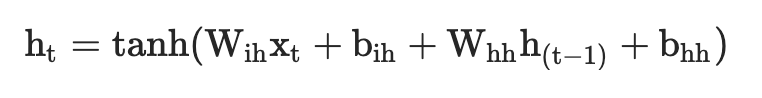

where h_t is the hidden state at time t, x_t is the input at time t, and h_{(t-1)} is the hidden state of the previous layer at time t-1 or the initial hidden state at time 0. Full credit to Pytorch for description, full citation in part 5. 

This model allowed us to feed in two arguments to the most basic form of RNN, our inputs, and our hidden layer. The first hidden layer was initialized to zeros by defaulted then updated through training. The sequences took the form of a list of tensors and a label representing the sentence with word embeddings and its emotion classification. 

### 2.2.5 Linear Classifier

At the end of a single run through our RNN, we feed the output of our hidden layer through a linear transformation so that we can classify based on the maximum likelihood. This transformation in our most basic model was of the form y=xA^T+b where y is our final output probability distribution for a sequence and x is the output of our hidden layer on the iteration corresponding to that sequence. 

### 2.2.6 Stopping

Our model stops iteration once it runs over all elements in a sequence. For an RNN, we represent each sentence as a sequence of vectors. For a single instance (a single sentence) the model iterates over all vectors (all words), produces the hidden layer, and produces output. Within training loss and gradients are calculated and this indicates the stoppping point for a single iteration. This goes for both training and validation. The stopping point for the entirety of training and validation is specified by the number of epochs and quantity of data we use. We opted for 2 epochs in our training runs. 

Another "stopping" point is done when we clip the gradient. While this does not cease iteration of the model, it does "stop" our gradient from increasing past a certain point which is to a single magntiude of 10. This solves the issue of an exploding gradient. 

### 2.2.7 Hyperparameters


In the RNN itself, we feed in only 2 arguments, the input size and the hidden dimension size. Our input size is 300, this is due to our choice of word embedding using [spaCy](https://spacy.io/usage/vectors-similarity). As for the hidden dimension in our original model, we opted for 512 to try and create an initial comparison of performance with the FFNN model from part 1. We adjust the hidden layer hyperparameter to see how it effects performance in part 3. 

Not directly within our RNN model but within our optimizer, we had 2 additional hyperparameters: learning rate and momentum. We did some readings [here](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) to learn more about the learning rate and momentum and how to select them. The learning rate relates to the amount that the weights are updated on each step of our SGD. Too big of a learning rate and we lose accuracy, too small and we do not converge quickly/effectively enough if at all so it is a balancing game. We opted for a "middle of the pack" learning rate that seems to be supported by the literature at .0001.

Momentum would typically default to 0 but we opted to leave it as non-zero. This was largely a consideration driven by thinking about performance. Momentum will allow our gradient to accelerate in the right direction thus speeding up convergence and helping to optimize our algorithm. We also looked at our previous example and the literature to be ok with the .9 selection. 

Also not directly within our model but related to training is the number of epochs we chose to run through. We used 2 for efficient runtime and to see the difference in accuracy 1 epoch after another. We test the effect of additional epochs in part 3. 

# Part 3: Analysis
From **Part 1** and **Part 2**, you will have two different models in hand for performing the same emotion detection task. In **Part 3**, you will conduct a comprehensive analysis of these models, focusing on two comparative settings.

## Part 3 Note
You will be required to submit the code used in finding these results on CMSX. This code should be legible and we will consult it if we find issues in the results. It is worth noting that in **Part 1** and **Part 2**, we primarily are considering the correctness of the code-snippets in the report. If your model is flawed in a way that isn’t exposed by those snippets, this will likely surface in your results for **Part 3**. We will deduct points for correctness in this section to reflect this and we will try to localize where the error is (or think it is, if it is opaque from your code). That said, we will be lenient about absolute performance (within reason) in this section.

## 3.1: Across-Model Comparison
In this section, you will report results detailing the comparison of the two models. Specifically, we will consider the issue of _fair comparison_<sup>5</sup>, which is a fundamental notion in NLP and ML research and practice. In particular, given model $A$, it is likely the case we can make a model $B$ that is computationally more complex and, hence, more costly and achieves superior performance. However, this makes for an unfair comparison. For our purposes, we want to study how the FFNN and RNN compare when we try to control for hyperparameters and other configurable values being of similar computational cost<sup>6</sup>. That said, it is impossible to have identical configurations as these are different models, i.e. the RNN simply has hyperparameters for which there are no analogues in the FFNN.


In the report you will need to begin by describing 3 pairs of configurations, with each pair being comprised of a FFNN configuration and a RNN configuration that constitute a _fair comparison_. You will need to argue for why the two parts of each pair are a fair comparison. Across the pairs, you should try different types of configurations (e.g. trying to resolve like questions of the form: _Does the FFNN perform better or worse when the hidden dimensionality is small as opposed to when it is large?_) and justify what you are trying to study by having the results across the pairs.


Next, you will report the quantitative accuracy of the 6 resulting models. You will
analyze these results and then move on to a more descriptive analysis.

The descriptive analysis can take one of two forms<sup>7</sup>:

1. _Nuanced quantitative analysis_ \
If you choose this option, you will need to further break down the quantitative statistics you reported initially. We provide some initial strategies to prime you for what you should think about in doing this: one possible starting point is to consider: if model $X$ achieves greater accuracy than model $Y$, to what extent is $X$ getting everything correct that $Y$ gets correct? Alternatively, how is model performance affected if you measure performance on a specific strata/subset of the reviews?

2. _Nuanced qualitative analysis_ \
If you choose this option, you will need to select individual examples and try to explain or reason about why one model may be getting them right whereas the other isn’t. Are there any examples that all 6 models get right or wrong and, if so, can you hypothesize a reason why this occurs?

In [ ]:
emotion_to_idx = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5,
}

In [ ]:
list(emotion_to_idx.keys())[list(emotion_to_idx .values()).index(0)]

'anger'

### 3.1.1 Configuration 1
Modify the code below for this configuration.

In [ ]:
h = 80
ffnn_config_1 = FFNN(len(vocab),h, len(emotion_to_idx)).to(get_device())
rnn_config_1 = RNN(300, h).to(get_device())
epochs = 2
train_and_evaluate(epochs, ffnn_config_1,train_loader,val_loader)
train_and_evaluate2(epochs, rnn_config_1, train_loader2, val_loader2,train_lengths,val_lengths)

0.3425


loss:  tensor(1.3785, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4205533596837945
class predictions:  [182. 301.  17.  25. 740.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [124. 140.   9.  19. 240.   0.]
predictive power:  0.4205533596837945
true positive rate by class:  [0.68131868 0.46511628 0.52941176 0.76       0.32432432        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0.7182


loss:  tensor(0.6298, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.7944664031620553
class predictions:  [254. 291. 235. 164. 321.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [223. 197. 198. 141. 246.   0.]
predictive power:  0.7944664031620553
true positive rate by class:  [0.87795276 0.67697595 0.84255319 0.8597561  0.76635514        nan]



loss:  tensor(1.6092, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.26877470355731226
class predictions:  [ 60.   2. 470.   0. 733.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 17.   0. 119.   0. 204.   0.]
predictive power:  0.26877470355731226
true positive rate by class:  [0.28333333 0.         0.25319149        nan 0.27830832        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.5964, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.25533596837944667
class predictions:  [ 72.   1. 498.   0. 694.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 15.   0. 123.   0. 185.   0.]
predictive power:  0.25533596837944667
true positive rate by class:  [0.20833333 0.         0.24698795        nan 0.26657061        nan]



### 3.1.1 Report
Describe configurations, report the results, and then perform a nuanced analysis

### Configurations
> This configuration has the same number of epochs (2), the same optimizer, but a smaller hidden layer value than the initial models calculated in parts 1 & 2. These configurations only have 80 hidden layers. \
### Results 
> **FFNN** \
Loss:  1.3785 -> 0.6298 \
accuracy:  0.7944664031620553 \
class predictions:  [254. 291. 235. 164. 321.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [223. 197. 198. 141. 246.   0.] \
predictive power:  0.7944664031620553 \
true positive rate by class:  [0.87795276 0.67697595 0.84255319 0.8597561  0.76635514        nan] \
> **RNN** \
loss:  1.6092 -> 1.5964 \
accuracy:  0.25533596837944667 \
class predictions:  [ 72.   1. 498.   0. 694.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [ 15.   0. 123.   0. 185.   0.] \
predictive power:  0.25533596837944667 \
true positive rate by class:  [0.20833333 0.         0.24698795        nan 0.26657061        nan] \

### Nuanced Analysis
> For a small number of hidden layers, the FFNN does remarkably better than the RNN. The loss decreases as the model learns from 1.3785 to 0.6298, meaning that our FFNN is learning in each epoch and producing more accurate results. The accuracy is high, 80%. Categories Anger, Fear, and Love, and Surprise had a true positive rate of at least 0.85.  Categories Joy and Sadness had true positive rates around 0.75, meaning the FFNN had more trouble learning from these two categories than the others. \

> On the other hand, the RNN did pretty poorly at learning on a small hidden size. This can be attributed to the fact that the number of hidden layers, 80, is much smaller than the size of the input embeddings, which is 300 in our RNN. The output shows the model actually got worse on the second epoch, with the loss slightly increasing from 1.6092 t0 1.5964. This means the RNN model didn't learn too much additional information and may be a sign that more epochs might be needed to truly make a difference.  \

> The RNN made predictions that heavily favor some categories over others. Most of the observations were for the Joy or Sadness categories, with few in fear, love, and surprise. The overfitting to a few categories may also indicate that more learning must take place for the RNN to make more accurate predictions. 
This shows that with a smaller hidden layer size, the FFNN will significantly outperform the RNN. 


### 3.1.2 Configuration 2
Modify the code below for this configuration.

In [ ]:
h = 1000
ffnn_config_2 = FFNN(len(vocab),h, len(emotion_to_idx)).to(get_device())
rnn_config_2 = RNN(300, h).to(get_device())
epochs = 2
train_and_evaluate(epochs, ffnn_config_2,train_loader,val_loader)
train_and_evaluate2(epochs, rnn_config_2, train_loader2, val_loader2,train_lengths,val_lengths)

0.3515


loss:  tensor(1.2613, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4806324110671937
class predictions:  [145. 178. 199.  25. 718.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [113. 125. 102.  21. 247.   0.]
predictive power:  0.4806324110671937
true positive rate by class:  [0.77931034 0.70224719 0.51256281 0.84       0.34401114        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0.7162


loss:  tensor(0.6056, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8142292490118577
class predictions:  [258. 258. 328. 188. 233.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [220. 192. 251. 158. 209.   0.]
predictive power:  0.8142292490118577
true positive rate by class:  [0.85271318 0.74418605 0.7652439  0.84042553 0.89699571        nan]



loss:  tensor(1.6060, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.23952569169960475
class predictions:  [  2.  13. 667.   0. 583.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  0.   3. 156.   0. 144.   0.]
predictive power:  0.23952569169960475
true positive rate by class:  [0.         0.23076923 0.23388306        nan 0.24699828        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.5936, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.24980237154150198
class predictions:  [ 37.   8. 578.   0. 642.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 16.   2. 135.   0. 163.   0.]
predictive power:  0.24980237154150198
true positive rate by class:  [0.43243243 0.25       0.23356401        nan 0.25389408        nan]



### 3.1.2 Report
Describe configurations, report the results, and then perform a nuanced analysis

### Configurations
> This configuration has the same number of epochs (2), the same optimizer, but a much larger hidden layer value than the initial models calculated in part 1 and 2. These configurations have 1000 hidden layers. \
### Results 
> **FFNN** \
Loss:  1.2613 -> 0.6056 \
accuracy:  0.8142292490118577 \
class predictions:  [258. 258. 328. 188. 233.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [220. 192. 251. 158. 209.   0.] \
predictive power:  0.8142292490118577 \
true positive rate by class:  [0.85271318 0.74418605 0.7652439  0.84042553 0.89699571        nan] \
> **RNN** \
loss:  1.6060 -> 1.5936 \
accuracy:  0.24980237154150198 \
class predictions:  [ 37.   8. 578.   0. 642.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [ 16.   2. 135.   0. 163.   0.] \
predictive power:  0.24980237154150198 \
true positive rate by class:  [0.43243243 0.25       0.23356401        nan 0.25389408        nan] \

### Nuanced Analysis
> Interestingly enough, the RNN gets a slightly lower accuracy, 0.2498, with the hidden layer dimension set to 1000 instead of 80. The only ones getting classified accurately are the same 275 in the Anger class, since the RNN classifies all but a few as being in the angry class. This model also does not significantly change loss in the second epoch. It goes from 1.6060 to 1.5936. The most significant change for the added hidden layers is that the RNN seems to overpredict joy and sadness to a greater extent. Seeing that the RNN does poorly with both large and small amounts of hidden layers, it seems that using less hidden layers might be better since it has a slightly lower amount of loss. 

> The FFNN on the other hand does slightly better with more hidden layers. The accuracy increases to 81.4% and loss decreases in the second epoch by a slight margin, roughly 0.01 to get a final loss of 0.6056. With more hidden layers, the true positivity rates of almost all the classes increase, with the sole exception of the class Surpise which doesn't have any expected or predicted. The predictions for the FFNN has pretty equal distribution of predictions with respect to the number of expected examples.  

> For the price of adding in many more hidden layers, there is not too much accuracy to be gained, although neither model has decreases predictive power with the increase in hidden layer dimensionality. Overall, the FFNN is still far outperforming the RNN. 



### 3.1.3 Configuration 3
Modify the code below for this configuration.

In [ ]:
h = 1000
ffnn_config_3 = FFNN(len(vocab),h, len(emotion_to_idx)).to(get_device())
rnn_config_3 = RNN(300, h).to(get_device())
epochs = 5
train_and_evaluate(epochs, ffnn_config_3,train_loader,val_loader)
train_and_evaluate2(epochs, rnn_config_3, train_loader2, val_loader2,train_lengths,val_lengths)

0.3463


loss:  tensor(1.2445, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5367588932806324
class predictions:  [340. 195. 207.  43. 480.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [198. 129. 110.  37. 205.   0.]
predictive power:  0.5367588932806324
true positive rate by class:  [0.58235294 0.66153846 0.53140097 0.86046512 0.42708333        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


0.7213


loss:  tensor(0.5555, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8189723320158103
class predictions:  [268. 206. 270. 164. 357.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [229. 174. 220. 147. 266.   0.]
predictive power:  0.8189723320158103
true positive rate by class:  [0.85447761 0.84466019 0.81481481 0.89634146 0.74509804        nan]


0.8711


loss:  tensor(0.5192, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8039525691699605
class predictions:  [234. 190. 206. 171. 464.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [220. 173. 186. 152. 286.   0.]
predictive power:  0.8039525691699605
true positive rate by class:  [0.94017094 0.91052632 0.90291262 0.88888889 0.61637931        nan]


0.9221


loss:  tensor(0.5041, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8229249011857708
class predictions:  [229. 172. 310. 136. 418.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [210. 160. 253. 130. 288.   0.]
predictive power:  0.8229249011857708
true positive rate by class:  [0.91703057 0.93023256 0.81612903 0.95588235 0.68899522        nan]


0.9505


loss:  tensor(0.4618, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.8371541501976285
class predictions:  [368. 233. 288. 157. 219.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [262. 193. 249. 144. 211.   0.]
predictive power:  0.8371541501976285
true positive rate by class:  [0.71195652 0.82832618 0.86458333 0.91719745 0.96347032        nan]



loss:  tensor(1.6065, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.23557312252964427
class predictions:  [   4.    0.   84.    0. 1177.    0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  1.   0.  19.   0. 278.   0.]
predictive power:  0.23557312252964427
true positive rate by class:  [0.25              nan 0.22619048        nan 0.23619371        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.5944, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.26324110671936757
class predictions:  [  2.  11. 261.   0. 991.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  1.   3.  83.   0. 246.   0.]
predictive power:  0.26324110671936757
true positive rate by class:  [0.5        0.27272727 0.31800766        nan 0.24823411        nan]


loss:  tensor(1.5963, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.2490118577075099
class predictions:  [863.  29. 368.   0.   5.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [207.   5. 100.   0.   3.   0.]
predictive power:  0.2490118577075099
true positive rate by class:  [0.23986095 0.17241379 0.27173913        nan 0.6               nan]


loss:  tensor(1.5922, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.266403162055336
class predictions:  [  0.   0. 547.   0. 718.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  0.   0. 150.   0. 187.   0.]
predictive power:  0.266403162055336
true positive rate by class:  [       nan        nan 0.27422303        nan 0.26044568        nan]


loss:  tensor(1.5949, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.25059288537549407
class predictions:  [  1.   7. 369.   0. 888.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  0.   1. 103.   0. 213.   0.]
predictive power:  0.25059288537549407
true positive rate by class:  [0.         0.14285714 0.27913279        nan 0.23986486        nan]



### 3.1.3 Report
Describe configurations, report the results, and then perform a nuanced analysis

### Configurations
> This configuration has the same number of hidden layers, the same optimizer, but a higher number of epochs than the prior two models, using 5 epochs instead of 2. 
### Results 
> **FFNN** \
loss:  1.2445 -> 0.5555 -> 0.5192 -> 0.5041 -> 0.4618 \
accuracy:  0.8371541501976285 \
class predictions:  [368. 233. 288. 157. 219.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [262. 193. 249. 144. 211.   0.] \
predictive power:  0.8371541501976285 \
true positive rate by class:  [0.71195652 0.82832618 0.86458333 0.91719745 0.96347032        nan] \
> **RNN** \
loss:  1.6065 -> 1.5944 -> 1.5963 -> 1.5922 -> 1.5949 \
accuracy:  0.25059288537549407 \
class predictions:  [  1.   7. 369.   0. 888.   0.] \
expected classes:  [275. 212. 300. 178. 300.   0.] \
classes guessed correctly:  [  0.   1. 103.   0. 213.   0.] \
predictive power:  0.25059288537549407 \
true positive rate by class:  [0.         0.14285714 0.27913279        nan 0.23986486        nan] \

### Nuanced Analysis
> For the FFNN, using more epochs vastly improves the predictive power and accuracy of the model, while also significanlty decreasing the loss, from 0.5887 when we used 2 epochs in configuration 2 to 0.4618. The use of more epochs to train the FFNN produces much more accurate results. With 5 epochs, the FFNN also improves on learning, which is clear by the high true positivity rates by class. Every class has improved, with many of the classes above 0.8. \
> The RNN however, does about the same with 5 epochs as with 2 in terms of accuracy, getting 25.05%.  The RNN with more epochs starts to really overpredicrt examples in the sadness category and really veers away from the anger category. In the next section, within-model comparison, we will further evaluate how higher number of epochs can affect the results of an RNN model. The true positivit rates per class stay about the same with 5 epochs as they have been with 2. \
> For FFNNs and potentially RNNs , adding more epochs far improves the model, increasing predictive power and true positivity rates. 


## Part 3.2: Within-model comparison
To complement **Part 3.1: Across-Model Comparison**, in **Part 3.2: Within-Model Comparison**, you will need to study what happens when you change parameters within a model. To limit your workload, you need only do this for the RNN; and you may use at most one RNN model from the prior section.

In the prior section, we discussed _fair comparison_. Anothr aspect of rigorous experimentation in NLP (and other domains) is the _ablation study_. In this, we _ablate_ or remove aspects of a more complex model, making it less complex, to evaluate whether each aspect was neccessary. To be concrete, for this part, you should train 4 variants of the RNN model and describe them as we do below:

1. Baseline model
2. Baseline model made more complex by modification $A$ (e.g. changing the hidden dimensionality from $h$ to $2h$).
3. Baseline model made more complex by modification $B$ (where $B$ is an entirely distinct/different update from $A$).
4. Baseline model with both modificatons $A$ and $B$ applied.

Under the framing of an ablation study, you woud describe this as beginning with model 4 and then ablating (i.e. removing) each of the two modifications, in turn; and then removing both to see if they were genuinely neccessary for the performance you observe.

Once you describe each of the four models, report the quantitative accuracy as in the previous section. Conclude by performing the **opposite** nuanced analysis from the one you did in the previous section (i.e. if in **Part 3.1: Across-Model Comparison** you did _Nuanced quanitative analysis_, for **Part 3.2: Within-Model Comparison** perform a _Nuanced qualitative analysis_ and vice versa).

In [ ]:
import pandas as pd
def evaluation_examps(model, val_loader, optimizer, lengths):
  model.eval()
  loss = 0
  correct = 0
  total = 0
  i = 0
  class_preds = np.zeros(6)
  class_exp = np.zeros(6)
  class_correct = np.zeros(6)
  examps = pd.DataFrame(columns = ["Output", "Predicted", "Correct"])
  for (input_batch, expected_out) in tqdm(val_loader, leave=False, desc="Validation Batches"):
    output,hidden = model(input_batch.to(get_device()),lengths[i])
    final_output = output[0].unsqueeze(0)
    total += output.size()[0]
    _, predicted = torch.max(final_output, 1)
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
    class_preds[predicted.to("cpu")] += 1
    class_exp[expected_out.to("cpu")] += 1
    cor = False
    if (expected_out.to("cpu") == predicted.to("cpu")):
      class_correct[predicted.to("cpu")] += 1
      cor = True

    loss += model.compute_loss(final_output, expected_out.to(get_device()))
    i += 1
    examps = examps.append({'Output': final_output, "Predicted":predicted, "Correct": cor}, ignore_index=True)
  loss /= len(val_loader)
  # Print validation metrics
  print("loss: ", loss)
  print("accuracy: ", correct/total)
  print("class predictions: ", class_preds)
  print("expected classes: ", class_exp)
  print("classes guessed correctly: ", class_correct)
  pred_power = np.sum(class_correct) / np.sum(class_preds)
  print("predictive power: ", pred_power)
  true_pos_per_class = class_correct / class_preds
  print("true positive rate by class: ", true_pos_per_class)
  return examps

def train_and_evaluate_examps(number_of_epochs, model, train_loader, val_loader,train_lengths,val_lengths):
  # , input_seq, gold_labels
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  for epoch in trange(number_of_epochs, desc="Epochs"):
    train_epoch2(model, train_loader, optimizer, train_lengths)
    examps = evaluation_examps(model, val_loader, optimizer,val_lengths)
  return examps

### 3.2.1 Configuration 1
Modify the code below for this configuration.

In [ ]:
h = 512
baseline_rnn  = RNN(300, h).to(get_device())
epochs = 5
outputs = train_and_evaluate_examps(epochs, baseline_rnn, train_loader2, val_loader2,train_lengths,val_lengths)
outputs.head()

loss:  tensor(1.6981, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.3067193675889328
class predictions:  [ 61. 354. 207.   0. 643.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 26.  69. 102.   0. 191.   0.]
predictive power:  0.3067193675889328
true positive rate by class:  [0.42622951 0.19491525 0.49275362        nan 0.2970451         nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(2.0350, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.308300395256917
class predictions:  [ 28. 127. 125.   3. 982.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 11.  27.  79.   2. 271.   0.]
predictive power:  0.308300395256917
true positive rate by class:  [0.39285714 0.21259843 0.632      0.66666667 0.27596741        nan]


loss:  tensor(1.6094, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.37470355731225297
class predictions:  [123. 105. 225.  29. 783.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 48.  25. 145.  11. 245.   0.]
predictive power:  0.37470355731225297
true positive rate by class:  [0.3902439  0.23809524 0.64444444 0.37931034 0.31289911        nan]


loss:  tensor(1.5409, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4782608695652174
class predictions:  [173. 159. 268.  95. 570.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 82.  99. 172.  42. 210.   0.]
predictive power:  0.4782608695652174
true positive rate by class:  [0.47398844 0.62264151 0.64179104 0.44210526 0.36842105        nan]


loss:  tensor(1.8256, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.48616600790513836
class predictions:  [209.  54. 280.  70. 652.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [122.  42. 174.  35. 242.   0.]
predictive power:  0.48616600790513836
true positive rate by class:  [0.58373206 0.77777778 0.62142857 0.5        0.37116564        nan]



,Output,Predicted,Correct
0,"[[tensor(-0.0243, device='cuda:0', grad_fn=<Un...","[tensor(0, device='cuda:0')]",False
1,"[[tensor(-4.8588, device='cuda:0', grad_fn=<Un...","[tensor(2, device='cuda:0')]",True
2,"[[tensor(-3.7083, device='cuda:0', grad_fn=<Un...","[tensor(4, device='cuda:0')]",True
3,"[[tensor(-10.6359, device='cuda:0', grad_fn=<U...","[tensor(2, device='cuda:0')]",True
4,"[[tensor(-1.3305, device='cuda:0', grad_fn=<Un...","[tensor(1, device='cuda:0')]",False


### 3.2.2 Configuration 2
Modify the code below for this configuration.

In [ ]:
class RNN2(nn.Module):
  def __init__(self,input_dim, h_dim, n_layers=1): # Add relevant parameters
    super(RNN2, self).__init__()
    # Fill in relevant parameters
    self.hidden_dim = h_dim
    self.input_dim = input_dim
    self.rnn = nn.RNN(input_dim, h_dim, batch_first=True)
    self.to_out = nn.Linear(h_dim, 6)
    nn.init.normal_(self.to_out.weight, mean=0, std=1)
    self.n_layers = n_layers
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
    self.softmax = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)	

  def forward(self, inputs, lens):
    h0 = torch.empty(1, 1, self.hidden_dim).to(get_device())
    nn.init.kaiming_uniform_(h0, mode='fan_in', nonlinearity='relu')
    output, hidden = self.rnn(inputs, h0)
    output = output[0][lens-1].unsqueeze(0)
    output = self.to_out(output)
    out = self.softmax(output)
    return out, hidden

  def load_model(self, save_path):
    self.load_state_dict(torch.load(save_path))
	
  def save_model(self, save_path):
    torch.save(self.state_dict(), save_path)
	

In [ ]:
#kaiming initialization
h = 512
mod_a_rnn  = RNN2(300, h).to(get_device())
epochs = 5
outputsa = train_and_evaluate_examps(epochs, mod_a_rnn, train_loader2, val_loader2,train_lengths,val_lengths)
outputsa.head()

loss:  tensor(2.1131, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.26403162055335966
class predictions:  [574. 167. 190.  77. 257.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [130.  42.  75.  17.  70.   0.]
predictive power:  0.26403162055335966
true positive rate by class:  [0.22648084 0.25149701 0.39473684 0.22077922 0.27237354        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.9105, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.3778656126482213
class predictions:  [164. 178. 272.  36. 614.   1.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 69.  52. 144.  14. 199.   0.]
predictive power:  0.3778656126482213
true positive rate by class:  [0.42073171 0.29213483 0.52941176 0.38888889 0.32410423 0.        ]


loss:  tensor(2.1824, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4426877470355731
class predictions:  [ 75.  73. 441.  43. 633.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 34.  60. 221.  19. 226.   0.]
predictive power:  0.4426877470355731
true positive rate by class:  [0.45333333 0.82191781 0.50113379 0.44186047 0.35703002        nan]


loss:  tensor(1.8362, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4932806324110672
class predictions:  [357. 218. 316.  38. 336.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [132. 128. 184.  18. 162.   0.]
predictive power:  0.4932806324110672
true positive rate by class:  [0.3697479  0.58715596 0.58227848 0.47368421 0.48214286        nan]


loss:  tensor(1.9030, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5375494071146245
class predictions:  [330. 113. 336. 103. 383.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [177.  87. 192.  40. 184.   0.]
predictive power:  0.5375494071146245
true positive rate by class:  [0.53636364 0.7699115  0.57142857 0.38834951 0.48041775        nan]



,Output,Predicted,Correct
0,"[[tensor(-8.2738, device='cuda:0', grad_fn=<Un...","[tensor(2, device='cuda:0')]",True
1,"[[tensor(-10.6097, device='cuda:0', grad_fn=<U...","[tensor(2, device='cuda:0')]",True
2,"[[tensor(-1.5131, device='cuda:0', grad_fn=<Un...","[tensor(4, device='cuda:0')]",True
3,"[[tensor(-11.1880, device='cuda:0', grad_fn=<U...","[tensor(2, device='cuda:0')]",True
4,"[[tensor(-0.1432, device='cuda:0', grad_fn=<Un...","[tensor(0, device='cuda:0')]",False


### 3.2.3 Configuration 3
Modify the code below for this configuration.

In [ ]:
class RNN3(nn.Module):
  def __init__(self,input_dim, h_dim, n_layers=1): # Add relevant parameters
    super(RNN3, self).__init__()
    # Fill in relevant parameters
    self.hidden_dim = h_dim
    self.input_dim = input_dim
    self.rnn = nn.RNN(input_dim, h_dim, batch_first=True, dropout = 0.5)
    self.to_out = nn.Linear(h_dim, 6)
    # nn.init.normal_(self.to_out.weight, mean=0, std=1)
    self.n_layers = n_layers
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
    self.softmax = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)	

  def forward(self, inputs, lens):
    # h0 = torch.empty(1, 1, self.hidden_dim).to(get_device())
    # nn.init.kaiming_uniform_(h0, mode='fan_in', nonlinearity='relu')
    # output, hidden = self.rnn(inputs, h0)
    output, hidden = self.rnn(inputs)
    output = output[0][lens-1].unsqueeze(0)
    output = self.to_out(output)
    out = self.softmax(output)
    return out, hidden

  def load_model(self, save_path):
    self.load_state_dict(torch.load(save_path))
	
  def save_model(self, save_path):
    torch.save(self.state_dict(), save_path)

In [ ]:
#including dropouts at a dropout rate of 0.5
h = 512
mod_b_rnn  = RNN3(300, h).to(get_device())
epochs = 5
outputsb = train_and_evaluate_examps(epochs, mod_b_rnn, train_loader2, val_loader2,train_lengths,val_lengths)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


loss:  tensor(1.4969, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.3422924901185771
class predictions:  [ 12.   6. 344.   0. 903.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [  3.   1. 168.   0. 261.   0.]
predictive power:  0.3422924901185771
true positive rate by class:  [0.25       0.16666667 0.48837209        nan 0.28903654        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.5732, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.39920948616600793
class predictions:  [137.  85. 442.   3. 598.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 56.  22. 220.   0. 207.   0.]
predictive power:  0.39920948616600793
true positive rate by class:  [0.40875912 0.25882353 0.49773756 0.         0.34615385        nan]


loss:  tensor(1.9280, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.37707509881422924
class predictions:  [432.  47. 243.  13. 530.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [134.  11. 153.   5. 174.   0.]
predictive power:  0.37707509881422924
true positive rate by class:  [0.31018519 0.23404255 0.62962963 0.38461538 0.32830189        nan]


loss:  tensor(1.5049, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.47114624505928854
class predictions:  [ 22. 270. 419.  10. 544.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 13. 135. 228.   7. 213.   0.]
predictive power:  0.47114624505928854
true positive rate by class:  [0.59090909 0.5        0.54415274 0.7        0.39154412        nan]


loss:  tensor(1.6019, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5367588932806324
class predictions:  [196. 232. 362.  39. 436.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [125. 120. 206.  21. 207.   0.]
predictive power:  0.5367588932806324
true positive rate by class:  [0.6377551  0.51724138 0.56906077 0.53846154 0.47477064        nan]



### 3.2.4 Configuration 4
Modify the code below for this configuration.

In [ ]:
class RNN4(nn.Module):
  def __init__(self,input_dim, h_dim, n_layers=1): # Add relevant parameters
    super(RNN4, self).__init__()
    # Fill in relevant parameters
    self.hidden_dim = h_dim
    self.input_dim = input_dim
    self.rnn = nn.RNN(input_dim, h_dim, batch_first=True, dropout = 0.5)
    self.to_out = nn.Linear(h_dim, 6)
    nn.init.normal_(self.to_out.weight, mean=0, std=1)
    self.n_layers = n_layers
		# Ensure parameters are initialized to small values, see PyTorch documentation for guidance
    self.softmax = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)	

  def forward(self, inputs, lens):
    h0 = torch.empty(1, 1, self.hidden_dim).to(get_device())
    nn.init.kaiming_uniform_(h0, mode='fan_in', nonlinearity='relu')
    output, hidden = self.rnn(inputs, h0)
    output = output[0][lens-1].unsqueeze(0)
    output = self.to_out(output)
    out = self.softmax(output)
    return out, hidden

  def load_model(self, save_path):
    self.load_state_dict(torch.load(save_path))
	
  def save_model(self, save_path):
    torch.save(self.state_dict(), save_path)

In [ ]:
#kaiming normal initialization and dropout rate of 0.5
h = 512
mod_both_rnn  = RNN4(300, h).to(get_device())
epochs = 5
outputs3 = train_and_evaluate_examps(epochs, mod_both_rnn, train_loader2, val_loader2,train_lengths,val_lengths)
outputs3.head()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


loss:  tensor(2.0728, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.291699604743083
class predictions:  [629.  61. 140. 208. 227.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [161.  20.  63.  53.  72.   0.]
predictive power:  0.291699604743083
true positive rate by class:  [0.25596184 0.32786885 0.45       0.25480769 0.31718062        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(2.0496, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.3786561264822134
class predictions:  [452.  96. 476. 174.  67.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [157.  41. 214.  44.  23.   0.]
predictive power:  0.3786561264822134
true positive rate by class:  [0.34734513 0.42708333 0.44957983 0.25287356 0.34328358        nan]


loss:  tensor(1.8000, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.44110671936758894
class predictions:  [103. 200. 433. 111. 418.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 51.  85. 217.  38. 167.   0.]
predictive power:  0.44110671936758894
true positive rate by class:  [0.49514563 0.425      0.50115473 0.34234234 0.39952153        nan]


loss:  tensor(2.5405, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.46561264822134385
class predictions:  [ 68. 161. 378.  45. 613.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 50.  95. 194.  11. 239.   0.]
predictive power:  0.46561264822134385
true positive rate by class:  [0.73529412 0.59006211 0.51322751 0.24444444 0.38988581        nan]


loss:  tensor(2.2494, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5462450592885375
class predictions:  [327. 250. 475.  10. 203.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [179. 134. 239.   4. 135.   0.]
predictive power:  0.5462450592885375
true positive rate by class:  [0.54740061 0.536      0.50315789 0.4        0.66502463        nan]



,Output,Predicted,Correct
0,"[[tensor(-1.0346, device='cuda:0', grad_fn=<Un...","[tensor(2, device='cuda:0')]",True
1,"[[tensor(-9.3047, device='cuda:0', grad_fn=<Un...","[tensor(2, device='cuda:0')]",True
2,"[[tensor(-9.0208, device='cuda:0', grad_fn=<Un...","[tensor(1, device='cuda:0')]",True
3,"[[tensor(-0.0266, device='cuda:0', grad_fn=<Un...","[tensor(0, device='cuda:0')]",True
4,"[[tensor(-0.1217, device='cuda:0', grad_fn=<Un...","[tensor(0, device='cuda:0')]",True


In [ ]:
#change names so not confusing
output_baseline = outputs
output_b = outputsb
output_a = outputsa
output_ab = outputs3

In [ ]:
def stringify(tup):
  ans = ""
  sent = tup[0]
  for s in sent:
    ans = ans + " " + s
  ans = ans + ". Category " + list(emotion_to_idx.keys())[list(emotion_to_idx.values()).index(tup[1])]
  return ans

In [ ]:
all_guessed_correct = output_ab[(output_ab.Correct == True) & (output_b.Correct == True) & (output_a.Correct == True) & (output_baseline.Correct == True)]
all_guessed_wrong = output_ab[(output_ab.Correct == False) &(output_b.Correct == False) & (output_a.Correct == False) & (output_baseline.Correct == False)]
ab_correct_only = output_ab[(output_ab.Correct == True) &(output_b.Correct == False) & (output_a.Correct == False) & (output_baseline.Correct == False)]
a_correct_only = output_ab[(output_ab.Correct == False) &(output_b.Correct == False) & (output_a.Correct == True) & (output_baseline.Correct == False)]
b_correct_only = output_ab[(output_ab.Correct == False) &(output_b.Correct == True) & (output_a.Correct == False) & (output_baseline.Correct == False)]
baseline_correct_only = output_ab[(output_ab.Correct == False) &(output_b.Correct == False) & (output_a.Correct == False) & (output_baseline.Correct == True)]
everything_but_ab = output_ab[(output_ab.Correct == False) &(output_b.Correct == True) & (output_a.Correct == True) & (output_baseline.Correct == True)]
a_makes_correct = output_ab[(output_ab.Correct == True) &(output_b.Correct == False) & (output_a.Correct == True) & (output_baseline.Correct == False)]
b_makes_correct = output_ab[(output_ab.Correct == True) &(output_b.Correct == True) & (output_a.Correct == False) & (output_baseline.Correct == False)]

In [ ]:
print("Guessed correctly by every model:", len(all_guessed_correct))
print("Guessed incorrectly by every model:", len(all_guessed_wrong))
print("Guessed correctly only by AB Model:", len(ab_correct_only))
print("Guessed correctly by A Model & AB Model:", len(a_makes_correct))
print("Guessed correctly by B Model & AB Model:", len(b_makes_correct))
print("Guessed correctly by A Model:", len(a_correct_only))
print("Guessed correctly by B Model:", len(b_correct_only))
print("Guessed correctly by Baseline Model:", len(baseline_correct_only ))
print("Guessed correctly by A Model, B Model, and Baseline Model:", len(everything_but_ab))

Guessed correctly by every model: 102
Guessed incorrectly by every model: 53
Guessed correctly only by AB Model: 72
Guessed correctly by A Model & AB Model: 87
Guessed correctly by B Model & AB Model: 104
Guessed correctly by A Model: 73
Guessed correctly by B Model: 78
Guessed correctly by Baseline Model: 62
Guessed correctly by A Model, B Model, and Baseline Model: 64


In [ ]:
k = 1
for i in all_guessed_wrong .index[0:5]:
  print(str(k) + ". " + stringify(val[i]))
  k = k + 1


1.  i am a big believer in the phrase that some people are all style no substance and i feel that if you have nothing worthwhile to say just dont say it. Category joy
2.  i feel idiotic calling again though. Category sadness
3.  i feel unimportant and small here lately. Category sadness
4.  i feel i have rushed moments where i begin to take this life here for granted i just look at them they look at me and my graced life becomes the stage again warts crushed worms under foot and all the other conflicts that come with it. Category anger
5.  i was out the exit door feeling strange because at the last stage the entire thing seemed to slip out of my hands like a slippery fish and also hopeful that i know what to do and if i can look at it positively it means just one more trip to retry. Category fear


### 3.2 (1-4) Report
Describe variants in the ablation style described, report the results, and then perform a nuanced analysis of the opposite type as before.

### Variants

All models are an RNN with 5 epochs, 512 hidden layers, and a learning rate of 0.01.  

1. Baseline model: RNN Described Above
2. Baseline model made more complex by modification $A$: Kaiming Initialization
3. Baseline model made more complex by modification $B$: Dropout Rate of 0.5
4. Baseline model with both modificatons $A$ and $B$ applied: Kaiming Initialization & Dropout Rate of 0.5

### Baseline model with both modificatons  𝐴  and  𝐵  applied

> What All Models Get Correct
```
 1. i couldn t help but feel slightly skeptical and apprehensive as i realized the tough task funes was taking on that night. Category fear
 2. i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed. Category anger
 3. i get why she is concerned because i have been pretty honest about feeling shitty about all of it. Category sadness
 4. i feel a little naughty whenever i wear such a colour combo. Category love
 5. i am feeling awfully lonely today and i dont want to burden any particular person with this because everyone has their own shit. Category sadness
```
These were 102 examples guessed correctly in all four RNN models, about 10%. We hypothosize this is because these sentences contain extreme words that strongly signal a category, such as "apprehensive" in sentence 1 (fear), "unkind" in sentece 2 (anger), and "lonely" in sentence 5 (sadness). \


> What Only Model AB Gets Correct
```
 1. i think that in this way though the readers will most likely agree with what i wrote and hopefully feel more passionate about scientific research. Category love
 2. i feel so frightened at the thought of opening up my heart. Category fear
 3. i got to christmas feeling positive about the future and hopeful that hospital admissions were finally behind me. Category joy
 4. i feel everyone should be valued at their worth and must have their primary rights. Category joy
 5. im feeling quite well acquainted with. Category joy
```
There are 72 examples that only get categorized correctly when both modifcations A and B are applied to our model. This might be because they are more complex examples and probably fall in one of the categories that the RNN initially did not overfit too. A lot of these examples are for joy ( Sentences 3 - 5). This could mean that the model with both dropout rate and kaiming normal initialization can make better distinctions between similar categories, such as joy and love. This model also does better with phrases, such as "hopefully feel more passionate" being categorized as love (sentence 1) even though we don't always think of science as being talked about in a 'loving' way.  


Now, let's discuss the impact of removing modifcation B (dropout rate) and only including the Kaiming Normal Distribution. The accuracy for the model without Dropout rate was slightly lower but not by a significant amount. Let's look at a few examples to see what is happening. 

### Baseline model with modificaton  𝐴 applied

> What only Model A Gets Correct
```
 1. im feeling more fucked up than last night. Category anger
 2. i was feeling somewhat irritable through the whole thing. Category anger
 3. i am nowhere perfect but i feel helpless to save my family because they are so far away. Category sadness
 4. i guess it s all about trying to internalize the serenity prayer without also feeling walked over and abused. Category sadness
 5. i know that feeling awkward and not having friends in a space contributes to this. Category sadness
```
Many of the examples that Kaiming Normal helps to classify are distinguishing sadness and anger from fear. Some of these, like "i feel awkward" (sentence 5) could easily be in the fear category, but only model A identifies this seperation. 


> What A Makes Correct
```
1.  i enjoy going to churches acquired there feeling is always so peaceful and tranquil thats why ive had a wish to visit pochayiv monastery and without comments it was really worthy. Category joy
2.  i feel im supposed to hate dams amp all the control of nature that they represent but sometimes they really are the most elegant amp awe inspiring structures. Category joy
3.  i mention that i feel really unwelcome. Category sadness
4.  im sure there are situations when this happens with the older crowd i feel its dangerous to do online dating when youre young. Category anger
5.  im feeling much better and im ready to get outta heaaa. Category joy
```
It is also important to think about what the addition of kaiming normal initializes makes correct. These are things that were correctly classified in model A or model AB but incorrectly in the baseline and model B. Here we can start to really see how the kaiming normal allows for the seperation of similar categories. Many of the examples A makes correct fall into the category of joy, which can have significant overlap with category love. It even allowed sentence 2, which has the phrase "I really hate dams" and "control of nature" as joy, signaling that normal initialization helps the model predict over the meaning of the whole sentence, not just a couple words like 'hate' and 'control' which are usually interpreted in a negative light. 



Now let's look at the model where modification A, kaiming normal initialization, is dropped but modifaction B, dropout rate, is kept. 

### Baseline model with both modificaton 𝐵 applied

> What only Model B Gets Correct
```
1.  i know she feels helpless but that kiss that cuddle the hug every morning and the love you every night. Category sadness
2.  i want nothing more than to continue this journey empowering women who because of their illness feel helpless and isolated. Category sadness
3.  i feel useless return false. Category sadness
4.  i still feel shaky but it is gradually getting better i have no idea what is going on. Category fear
5.  i actually just took a two hour break because i was feeling too pissed to keep writing. Category anger
```
First, let's consider some examples that only this model correctly identifies. Dropout rate seems to do well at supporting the classification of anger, seperation, and fear. The dropout rate helps the model not to overpredict specific categories, which is evident in sentence 1. Although it says, "that kiss that cuddle" and "the love every night", the model was able to stay away from classifying the example of love because of less overprediction and correctly identify it as being in the sadness category. 


> What B Makes Correct
```
1.  i shouldnt feel threatened by that. Category fear
2.  ive read from others who have gone through similar circumstances it appears quite common and helps me feel less neurotic. Category fear
3.  i try to share what i bake with a lot of people is because i love people and i want them to feel loved. Category love
4.  i didn t consider that she maybe had difficulty in feeling accepted into a certain group of people and she was afraid of being rejected. Category love
5.  i anticipated feeling ecstatic jubilant over the moon wired giddy. Category joy
```
Let's also analyze what adding the dropout rate makes correct. This means the AB Model and the B Model correctly classified these examples but the baseline and Model A did not. One that surprised me was sentence 3. It seems that this should be an easy sentence to identify, saying "i love people and i want them to feel loved". Having a dropout rate may lead to the correct identification of this example because of the tendency to lean towards the joy category. This makes sense for sentence 1, since "threatened" could make a model without a dropout rate lean too much towards the angry category. 


Lastly, lets look at the model where both modifcations A and B were not included.

### Baseline model

> What Only Baseline Gets Correct
```
1.  i just feel awful and unlovable and thoroughly sorry for myself. Category sadness
2.  i can offer is that i felt like reggie must feel a kind of carefree power except unlike her expansive drive it didn t last more than a second. Category joy
3.  i feel that my charlie card is much more valuable than my credit card. Category joy
4.  i will feel comfortable handing it over to an editor. Category joy
5.  i have to admit that i m feeling quite gloomy today the first real day on my own in atlanta. Category sadness
```
First off, we were curious to see what the baseline model predicted correctly but the addition of the kaiming normal initialization and/or the dropout rate would then incorrectly identify. I think some of these examples are hard to classify, and the baseline just got a little "lucky", probably because the tendency to overclassify towards joy and sadness without either modification. For example, it would be hard to with certainty deduce that "i feel that my charlie card is much more valuable than my credit card" (sentence 3) should be in category joy, and same with sentence 4, "I will feel confortable handing it over to my editor". Neither sentence seems overly joyful. 

> After looking at the baseline model, we were curious about some of the other results that don't strictly fit into one of the categories already analyzed. Below, we look at what every model except for Model AB gets correct and what type of examples get misclassified by all 4 models. 

> What Everything but AB Gets Correct
```
1.  im feeling a little better and with more christmas spirit i thought that by this date id had all my christmas decorations up but im not finish even with the lights. Category joy
2.  im feeling generous so i think ill add a few more bonuses such as my santa babes from my gallery of perversion. Category joy
3.  i feel like im a gorgeous person. Category joy
4.  i knew just the thing he needed what every guy needs when he s feeling overwhelmed james bond. Category fear
5.  im feeling artistic here are a couple of drawings i did in the dust on ms car after it rained a couple of months ago. Category joy
```
Above are examples of sentences all the models get correct except when you add both modifications in. Most of these are in the joy category, which tends to get overpredicted to in more basic versions of our RNN. With both modifications, we think examples that aren't as clearly and decively in the joy category will get overpredicted. 

> What Nothing Gets Correct
```
1.  i am a big believer in the phrase that some people are all style no substance and i feel that if you have nothing worthwhile to say just dont say it. Category joy
2.  i feel idiotic calling again though. Category sadness
3.  i feel unimportant and small here lately. Category sadness
4.  i feel i have rushed moments where i begin to take this life here for granted i just look at them they look at me and my graced life becomes the stage again warts crushed worms under foot and all the other conflicts that come with it. Category anger
5.  i was out the exit door feeling strange because at the last stage the entire thing seemed to slip out of my hands like a slippery fish and also hopeful that i know what to do and if i can look at it positively it means just one more trip to retry. Category fear
```
Roughly 5% of the examples never get classified correctly in any of the models of this abilation study. Some of these have keywords that strongly shift the meaning to one category when in reality it is another. Take sentence 2, where although it says "i feel idiodic ...", it is sadness. Usually humans use idiodic to describe someone else they are very angry as. This is the same case in sentence 5 where phrases "hopeful" and "look at it positively" can shift the meaning towards joy when it is really in category fear. 



### Conclusions of Abolation Study

> **Kaiming Normal Initialization** \
Modication A, the kaiming normal initialization, helped to classify examples that could have overlap between fear and sadness at a much higher rate than without it. Therefore, we conclude that modification A makes a significant difference in improving our RNN model. 

> **Dropout Rate** \
Modification B, the addition of a dropout rate of 0.5, helped to keep the RNN from overpredicting on classes where it initially made better guesses, categories sadness and joy. This allowed more examples from love and fear to be correctly sorted. Therefore, we conclude that modification N makes a significant difference in improving our RNN model. 

> **Chosen Model** \
After decididing that both modifications improve our model and our above analysis concluding that the model with both does do the best at correctly identifying the correct category, we decide that our best model is **Model AB**.

# Part 4: Questions
In **Part 4**, you will need to answer the three questions below. We expect answers tobe to-the-point; answers that are vague, meandering, or imprecise **will receive fewer points** than a precise but partially correct answer.

## 4.1 Q1
Earlier in the course, we studied models that make use of _Markov_ assumptions. Recurrent neural networks do not make any such assumption. That said, RNNs are known to struggle with long-distance dependencies. What is a fundamental reason for why this is the case?

The fundamental reason for this being the case is the math that goes into updating/learning in a recurrent Neural Network, it is known as the problem of the "vanishgin gradient". As an RNN goes through a sequence, learning, it feeds the hidden state from the previous object it is analyzing to the next object it is analyzing. Once it reaches the end of a particular sequence, it is able to make a prediction. This prediction is then compared against the proper classification to gain a concept of accuracy/error using a loss function. This loss is then used in backward propogation through the RNN model to update the weights for each node in the network based on their gradients. Here is where the issue is. As we backpropogate, the first adjustment will be largest but as we move further and further back, the adjustments to the weights within the network become smaller and smaller as the next adjustments are made with respect to the previous adjustments which are reducing the gradient. This means moving backwards through a sequence will be constantly reducing the gradient thus lessening the relationship between any word and its predessecors, with further relationships having a bigger difference in gradient and thus how much their weights are adjusted. This is why long-distance dependencies are harder to learn in an RNN.

## 4.2 Q2
In applying RNNs to tasks in NLP, we have discovered that (at least for tasks in English) feeding a sentence into an RNN backwards (i.e. inputting the sequence of vectors corresponding to ($course$, $great$, $a$, $is$, $NLP$) instead of ($NLP$, $is$, $a$, $great$, $course$)) tends to improve performance. Why might this be the case?

In english, the words that may be the most important for identification may be the first few words. Another way to think about it is that the subject of a sentence tends to be earlier in the sentence. For example, "NLP is a great course" and "Python is a great course" have different meanings but the last 4 words are the same. As mentioned above, RNNs have trouble with long-term dependencies which means that feeding the sentence in the "normal way" would place more emphasis on the last few words in the sequence and not giving great information on how to classify. Putting the sequence in reverse can make the weight of the most relevant information more important.  

Another note, in a task like this, we embed the words or represent them in vector space somehow. Both the "normal" way and feeding in the sentence backward are valid because it's just going to be a different representation of the data that the network can learn on. 

## 4.3 Q3
In using RNNs and word embeddings for NLP tasks, we are no longer required to engineer specific features that are useful for the task; the model discovers them automatically. Stated differently, it seems that neural models tend to discover better features than human researchers can directly specify. This comes at the cost of systems having to consume tremendous amounts of data to learn these kinds of patterns from the data. Beyond concerns of dataset size (and the computational resources required to process and train using this data as well as the further environmental harm that results from this process), why might we disfavor RNN models?

You might disfavor an RNN model based on the classification task at hand. The RNN has advantages, but also disadvantages over other NN models that could be used. 

The major drawback, as already discussed, a simple RNN will not be able to handle long-term dependencies well due to the vanishign gradient problem. This can be solved by making adjustments like making the model bidirectional, using LSTM, or taking other steps to increase the "long-term memory" of the model but these are often still not good enough for the tasks at hand. As such, NLP tasks that have very long term dependencies (perhaps ones involving entire texts or long speeches) are likely not an instance where an RNN would be favored.

Another instance where you would disfavor the RNN model would be if the task was almost "too simple" for it. For instance, learning or approximating a function. That is, learning the parameters that would go into a one-to-one mapping. At this point, the RNN is almost too complex for this task and it would be simpler and more sensical to regress to a more basic NN like a Feed Forward NN (of which the RNN is an extension of) not only for computational efficiency but for interprettability and performance of results. 

# Part 5: Miscellaneous
List the libraries you used and sources you referenced and cited (labelled with the section in which you referred to them). Include a description of how your group split
up the work. Include brief feedback on this asignment.


**Libraries** \
pytorch nn: use in creating the rnn (2.1) and modifying the rnn (3.1 - 3.2)\
spacy: use in the preprocessing section of (2.1) to create word embeddings for the models \
pandas: used to create dataframes to store examples of which modifications correctly/incorrectly classified data in 3.2 \

**References** \
https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html (2.1) 
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html (2.1, 3.1, 3.2)
https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb (2.1)
https://colab.research.google.com/drive/15dn5I-Rjjsq21QYZK0A6DyeKzUVyouVq#scrollTo=qkuEJvepTeAP (2.1)
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html (2.1)
https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138 (3.2) 
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ (3.2)


**Work Split** \
Jenna and Gian worked together to identify the 4 errors in part 1 and Jenna worte the part 1 report. Gian did most of the builing out of the RNN model and wrote the part 2 report, but both Jenna and Gian spent a great deal of effort on part 2.1 of the project. Jenna built out the code for and wrote the analyses for part 3.1 and 3.2 of the project. Gian wrote the part 4 report and submitted to kaggle. 

**Each section must be clearly labelled, complete, and the corresponding pages should be correctly assigned to the corresponding Gradescope rubric item.** If you follow these steps for each of the 4 components requested, you are guaranteed full credit for this section. Otherwise, you will receive no credit for this section.

# Part 6: Kaggle Submission

In [ ]:
h = 512
mod_submission_rnn  = RNN4(300, h).to(get_device())
epochs = 10
outputs_sub = train_and_evaluate_examps(epochs, mod_submission_rnn, train_loader2, val_loader2,train_lengths,val_lengths)
outputs_sub.head()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


loss:  tensor(1.9370, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.29802371541501976
class predictions:  [ 90. 242. 174. 121. 638.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 28.  53.  73.  35. 188.   0.]
predictive power:  0.29802371541501976
true positive rate by class:  [0.31111111 0.21900826 0.41954023 0.2892562  0.29467085        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


loss:  tensor(1.9605, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.34466403162055337
class predictions:  [619.  63. 263.  60. 259.   1.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [167.  27. 134.  21.  87.   0.]
predictive power:  0.34466403162055337
true positive rate by class:  [0.26978998 0.42857143 0.5095057  0.35       0.33590734 0.        ]


loss:  tensor(2.1363, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.41185770750988143
class predictions:  [ 68.  67. 437. 220. 473.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 35.  45. 210.  48. 183.   0.]
predictive power:  0.41185770750988143
true positive rate by class:  [0.51470588 0.67164179 0.4805492  0.21818182 0.38689218        nan]


loss:  tensor(1.7350, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.48458498023715413
class predictions:  [447. 145. 371.  39. 263.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [171. 102. 200.  18. 122.   0.]
predictive power:  0.48458498023715413
true positive rate by class:  [0.38255034 0.70344828 0.53908356 0.46153846 0.46387833        nan]


loss:  tensor(2.4929, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.47035573122529645
class predictions:  [192. 435. 485.  44. 109.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [118. 153. 241.  17.  66.   0.]
predictive power:  0.47035573122529645
true positive rate by class:  [0.61458333 0.35172414 0.49690722 0.38636364 0.60550459        nan]


loss:  tensor(1.9300, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.566798418972332
class predictions:  [262. 211. 278. 174. 340.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [163. 124. 180.  61. 189.   0.]
predictive power:  0.566798418972332
true positive rate by class:  [0.6221374  0.58767773 0.64748201 0.35057471 0.55588235        nan]


loss:  tensor(2.5648, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.4893280632411067
class predictions:  [256. 542. 284.  67. 116.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [154. 178. 176.  27.  84.   0.]
predictive power:  0.4893280632411067
true positive rate by class:  [0.6015625  0.32841328 0.61971831 0.40298507 0.72413793        nan]


loss:  tensor(2.0911, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5399209486166008
class predictions:  [354. 174. 302.  46. 389.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [176. 116. 172.  28. 191.   0.]
predictive power:  0.5399209486166008
true positive rate by class:  [0.49717514 0.66666667 0.56953642 0.60869565 0.49100257        nan]


loss:  tensor(2.5987, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5312252964426878
class predictions:  [321. 283. 426. 140.  95.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [174. 149. 225.  53.  71.   0.]
predictive power:  0.5312252964426878
true positive rate by class:  [0.54205607 0.52650177 0.52816901 0.37857143 0.74736842        nan]


loss:  tensor(2.5224, device='cuda:0', grad_fn=<DivBackward0>)
accuracy:  0.5660079051383399
class predictions:  [ 98. 227. 361. 100. 479.   0.]
expected classes:  [275. 212. 300. 178. 300.   0.]
classes guessed correctly:  [ 82. 131. 216.  63. 224.   0.]
predictive power:  0.5660079051383399
true positive rate by class:  [0.83673469 0.57709251 0.59833795 0.63       0.46764092        nan]



,Output,Predicted,Correct
0,"[[tensor(-13.7277, device='cuda:0', grad_fn=<U...","[tensor(2, device='cuda:0')]",True
1,"[[tensor(-10.2589, device='cuda:0', grad_fn=<U...","[tensor(4, device='cuda:0')]",True
2,"[[tensor(-19.1430, device='cuda:0', grad_fn=<U...","[tensor(2, device='cuda:0')]",True
3,"[[tensor(-9.3424, device='cuda:0', grad_fn=<Un...","[tensor(4, device='cuda:0')]",False
4,"[[tensor(-0.6752, device='cuda:0', grad_fn=<Un...","[tensor(0, device='cuda:0')]",True


In [ ]:
# Create Kaggle submission function
kaggle_model = mod_submission_rnn
rnn_document_preprocessor = lambda x: rnn_preprocessing(x, True) # This is for your RNN
file_name = "submission.csv"
ffnn_document_preprocessor = lambda x: convert_to_vector_representation(x, word2index, True)

In [ ]:
padded_test.size()

torch.Size([1934, 66, 300])

In [ ]:
def generate_submission(filename, model, document_preprocessor, test):
    # test_vectorized = document_preprocessor(test)
    test_vectorized = test
    with Path(file_name).open("w") as fp:
        fp.write("Id,Predicted\n")
        i = 0
        for idx, input_vector in tqdm(enumerate(test_vectorized), total=len(test)):
            output = model(torch.Tensor(input_vector).unsqueeze(0).to(get_device()), test_lengths[i])
            i += 1
            _, pred = torch.max(output[0], 1)
            fp.write(f"{idx},{int(pred)}\n")
    return

In [ ]:
generate_submission(file_name, kaggle_model, rnn_document_preprocessor, padded_test)

# Live running demo

In [ ]:
#@title Emotion Detection
#@markdown Enter a sentence to see the emotion
input_string = "I am so joyful!" #@param {type:"string"}
model_type = "baseline_rnn" #@param ["baseline_ffnn", "baseline_rnn", "mod_a_rnn", "mod_b_rnn", "both_mods_rnn", "ffnn_config_1", "rnn_config_1", "ffnn_config_2", "rnn_config_2", "ffnn_config_3", "rnn_config_3"]
from IPython.display import HTML

output = ""

# BAD THING TO DO BELOW!!
model_used = globals()[model_type]

with torch.no_grad():
    if "ffnn" in model_type:
        vec_in = ffnn_document_preprocessor([[input_string]])[0]
        model_output = model_used(torch.Tensor(vec_in).unsqueeze(0)).cpu().squeeze(0)
    else:
        # RUN MODEL
        vec_in = rnn_document_preprocessor([[input_string]])[0]
        model_output = model_used(torch.Tensor(vec_in).unsqueeze(0)).cpu().squeeze(0)
    #print(torch.cat([torch.Tensor(z).unsqueeze(0) for z in model_inputs]).unsqueeze(0).shape)
    #model_output = model_used(torch.cat([torch.Tensor(z).unsqueeze(0) for z in model_inputs]).unsqueeze(0))
    #print(model_output.shape)
predicted = torch.argmax(model_output)
# MAP BACK TO EMOTION
# print(int(predicted))
emotion = idx_to_emotion[int(predicted)]

# Generate nice display
output += '<p style="font-family:verdana; font-size:110%;">'
output += " Input sequence: "+input_string+"</p>"
output += '<p style="font-family:verdana; font-size:110%;">'
output += f" Emotion detected: {emotion}</p><hr>"
output = "<h3>Results:</h3>" + output

display(HTML(output))

KeyError: ignored